In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from textCNN import textCNN
import word2vector
import Pretrained_embedding
from sklearn.model_selection import train_test_split
import Train

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [2]:
with open('../../dataset/MovieReview/rt-polaritydata/rt-polarity.pos', 'r', encoding='latin-1') as f:
    pos_sentences = f.readlines()

In [3]:
with open('../../dataset/MovieReview/rt-polaritydata/rt-polarity.neg', 'r', encoding='latin-1') as f:
    neg_sentences = f.readlines()

## normalized sentences

In [4]:
pos_sentences = [word2vector.normalizeString(sentence) for sentence in pos_sentences]
neg_sentences = [word2vector.normalizeString(sentence) for sentence in neg_sentences]

# a. using word2vector

## 1.build vocab

In [5]:
Vocab = word2vector.Vocab('vocab')

for i in pos_sentences:
    Vocab.addSentence(i)
    
for i in neg_sentences:
    Vocab.addSentence(i)

## 2.transform sentences to index sequence

In [6]:
MAX_LEN = 20
embedding_tensors = None
vocab_size = Vocab.num_vocab
print('num of vocab', vocab_size)

pos_seq = np.asarray([word2vector.indexesFromSentence(Vocab, sentence, MAX_LEN) for sentence in pos_sentences])
neg_seq = np.asarray([word2vector.indexesFromSentence(Vocab, sentence, MAX_LEN) for sentence in neg_sentences])

num of vocab 18161


In [7]:
print('pos',pos_seq.shape)
print('neg',neg_seq.shape)

pos (5331, 20)
neg (5331, 20)


# b. using glove pre-trained embedding

In [5]:
Glove = Pretrained_embedding.pre_embedding('glove')
Glove.init()

In [6]:
MAX_LEN = 20
vocab_size = len(Glove.word2index)

pos_seq = np.asarray([Glove.sentence2seq(sentence, MAX_LEN) for sentence in pos_sentences])
neg_seq = np.asarray([Glove.sentence2seq(sentence, MAX_LEN) for sentence in neg_sentences])

print('pos',pos_seq.shape)
print('neg',neg_seq.shape)
print('num of vocab', vocab_size)

embedding_tensors = torch.FloatTensor(Glove.embedding).to(device)

pos (5331, 20)
neg (5331, 20)
num of vocab 400003


## prepare data for training 

In [7]:
x_train, x_test, y_train, y_test = train_test_split(np.concatenate([pos_seq, neg_seq]), 
                                                    np.concatenate([np.ones(len(pos_seq)), np.zeros(len(neg_seq))]), 
                                                    test_size=0.1, random_state=2)

In [8]:
print('x_train',x_train.shape)
print('y_train',y_train.shape)
print('x_test',x_test.shape)
print('y_test',y_test.shape)

x_train (9595, 20)
y_train (9595,)
x_test (1067, 20)
y_test (1067,)


In [9]:
x_train_tensors = torch.LongTensor(x_train).to(device)
y_train_tensors = torch.LongTensor(y_train).to(device)

x_test_tensors = torch.LongTensor(x_test).to(device)
y_test_tensors = torch.LongTensor(y_test).to(device)

## training

In [15]:
model = textCNN(vocab_size=vocab_size, seq_length=MAX_LEN,filter_sizes=[2, 3, 4, 5],drop_out_rate=0.5,
                embedding_size=300, num_labels=2, embedding=embedding_tensors).to(device)

iter 1 / 100
0m 4s (- 6m 58s) train loss: 0.282.  val loss: 0.559.  train acc: 0.885.  val acc: 0.756
val acc increase from 0.000 to 0.756, save models

iter 2 / 100
0m 13s (- 10m 39s) train loss: 0.253.  val loss: 0.568.  train acc: 0.895.  val acc: 0.757
val acc increase from 0.756 to 0.757, save models

iter 3 / 100
0m 22s (- 11m 58s) train loss: 0.220.  val loss: 0.596.  train acc: 0.911.  val acc: 0.750

iter 4 / 100
0m 25s (- 10m 20s) train loss: 0.212.  val loss: 0.617.  train acc: 0.916.  val acc: 0.750

iter 5 / 100
0m 29s (- 9m 18s) train loss: 0.198.  val loss: 0.651.  train acc: 0.922.  val acc: 0.741

iter 6 / 100
0m 33s (- 8m 37s) train loss: 0.193.  val loss: 0.635.  train acc: 0.925.  val acc: 0.759
val acc increase from 0.757 to 0.759, save models

iter 7 / 100
0m 42s (- 9m 23s) train loss: 0.179.  val loss: 0.747.  train acc: 0.932.  val acc: 0.741

iter 8 / 100
0m 46s (- 8m 50s) train loss: 0.168.  val loss: 0.683.  train acc: 0.937.  val acc: 0.760
val acc increase 

<Figure size 432x288 with 0 Axes>

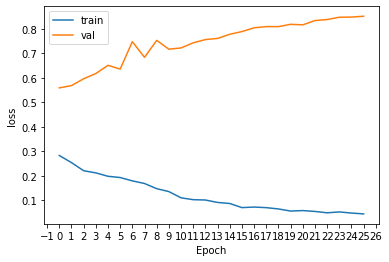

<Figure size 432x288 with 0 Axes>

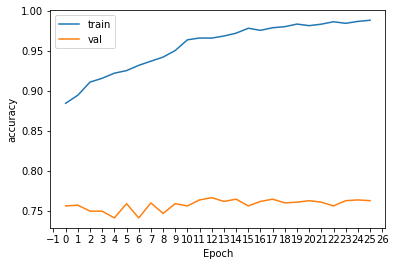

In [17]:
Train.train(input_train_tensors=x_train_tensors, output_train_tensors=y_train_tensors, 
            input_val_tensors=x_test_tensors, output_val_tensors=y_test_tensors,
            model=model, epoches=100, batch_size=50, print_every=1, plot_every=1, learning_rate=0.001,
           patience = 5, early_stop=20)